In [78]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download en_core_web_sm

In [80]:
pd.set_option('max_colwidth', 400)

### Набор данных
[
SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being **ham** (legitimate) or **spam**.

In [175]:
!wget -q https://raw.githubusercontent.com/bzhenka/NLP/main/spam_data.csv

In [176]:
data = pd.read_csv('spam_data.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [82]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [83]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

### Очистка

Стоп-слова для английского языка в spaCy

In [84]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"same seem otherwise whether twelve was ’ve last well below on put a three it hence somehow five under them own get you from go when various she were does first never our alone therein move meanwhile each wherein noone such ours full in ‘m ’ll an take thus call eleven herself per always between sometimes give become whoever moreover least ‘ll together regarding more these everywhere whenever latterly less behind further at fifty doing your although here down n’t the yourselves of seems whom everyone how none by besides could serious upon twenty into next else anyway if often anyone that throughout hers is his through yourself too their across for other both some afterwards ’d every one 've enough namely former over amount within than thru ten against very almost thereby done front now hereupon say mine its whole has beside two anyhow nor someone anywhere top thereafter my keep name four would most no somewhere elsewhere itself because became however again others much though becoming be

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [85]:
%%time

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

CPU times: user 48 s, sys: 156 ms, total: 48.2 s
Wall time: 1min


,label,text,cleaned_text
2281,0,"I hav almost reached. Call, i m unable to connect u.",hav reach m unable connect u.
653,0,Fine i miss you very much.,fine miss
4379,0,Done it but internet connection v slow and canÛ÷t send it. Will try again later or first thing tomo.,internet connection v slow canû÷t send try later thing tomo
312,0,He says he'll give me a call when his friend's got the money but that he's definitely buying before the end of the week,say friend get money definitely buy end week
4433,0,Sounds great! Im going to sleep now. Have a good night!,sound great m go sleep good night


### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

##### Стоп-слова

In [87]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'same seem ltd otherwise whether twelve was last well below on put a three it hence somehow five under them own get you from go when she were fill first never our alone therein move meanwhile each wherein noone such ours full in inc an sincere take thus call eleven herself per always between sometimes give become whoever moreover least together amoungst more these everywhere whenever latterly less behind further at fifty your although here down mill the yourselves of seems whom everyone how none by besides could serious upon twenty into next else anyway if often anyone that throughout hers is his through couldnt yourself too their across for other both some afterwards every one enough namely former over cant con amount within than thru bill ten against very almost thereby done found front now hereupon mine its de whole has beside two anyhow nor someone anywhere top thereafter my keep name thick detail four would most no somewhere elsewhere itself because became however eg again others 

This list of English stop words is taken from the "Glasgow Information Retrieval Group". The original list can be found at
http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

[Stop Word Lists in Free Open-source Software Packages](https://aclanthology.org/W18-2502.pdf)

#### Train/test split & fit

In [88]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [89]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#### Логистическая регрессия

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [91]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.97      0.82      0.89       186

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



#### DecisionTreeClassifier

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
dtc = DecisionTreeClassifier().fit(X_train_vectorized, y_train)
preds = dtc.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1207
           1       0.94      0.88      0.91       186

    accuracy                           0.98      1393
   macro avg       0.96      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393



#### Naive Bayes

In [94]:
from sklearn.naive_bayes import MultinomialNB

In [95]:
nb = MultinomialNB().fit(X_train_vectorized, y_train)
preds = nb.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1207
           1       0.91      0.87      0.89       186

    accuracy                           0.97      1393
   macro avg       0.94      0.93      0.94      1393
weighted avg       0.97      0.97      0.97      1393



### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



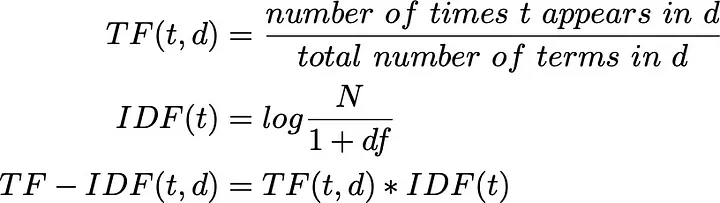

In [96]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

#### LogisticRegression

In [97]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



#### Naive Bayes

In [98]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       1.00      0.71      0.83       186

    accuracy                           0.96      1393
   macro avg       0.98      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



#### DecisionTreeClassifier

In [99]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier())
    ]
).fit(X_train, y_train)

preds = pipe.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1207
           1       0.90      0.88      0.89       186

    accuracy                           0.97      1393
   macro avg       0.94      0.93      0.94      1393
weighted avg       0.97      0.97      0.97      1393



In [100]:
def show_results(grid_search):
  results = pd.DataFrame(grid_search.cv_results_)
  results["params_str"] = results.params.apply(str)
  results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
  mean_scores = results.pivot(
      index="iter",
      columns="params_str",
      values="mean_test_score",
  )
  ax = mean_scores.plot(legend=False, alpha=0.6)

  labels = [
      f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
      for i in range(grid_search.n_iterations_)
  ]

  ax.set_xticks(range(grid_search.n_iterations_))
  ax.set_xticklabels(labels, rotation=45, multialignment="left")
  ax.set_title("Scores of candidates over iterations")
  ax.set_ylabel("Mean test score", fontsize=15)
  ax.set_xlabel("Iterations", fontsize=15)
  plt.tight_layout()
  plt.grid()
  plt.show()

### Оптимизация гиперпараметров

In [ ]:
def customGridSearch(pipeline, parameter_grid):
  grid_search = HalvingGridSearchCV(
      pipeline,
      param_grid=parameter_grid,
      n_jobs=-1,
      verbose=1,
      cv=3,
      scoring='f1',
      random_state=2023,
  )
  grid_search.fit(X_train, y_train)
  return grid_search

##### TF-IDF DecisionTreeClassifier

In [139]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier(random_state=2023))
    ]
)

In [140]:
parameter_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
}

In [141]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [105]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1207
           1       0.93      0.81      0.86       186

    accuracy                           0.97      1393
   macro avg       0.95      0.90      0.92      1393
weighted avg       0.97      0.97      0.97      1393



In [106]:
grid_search.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 20,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l1'}

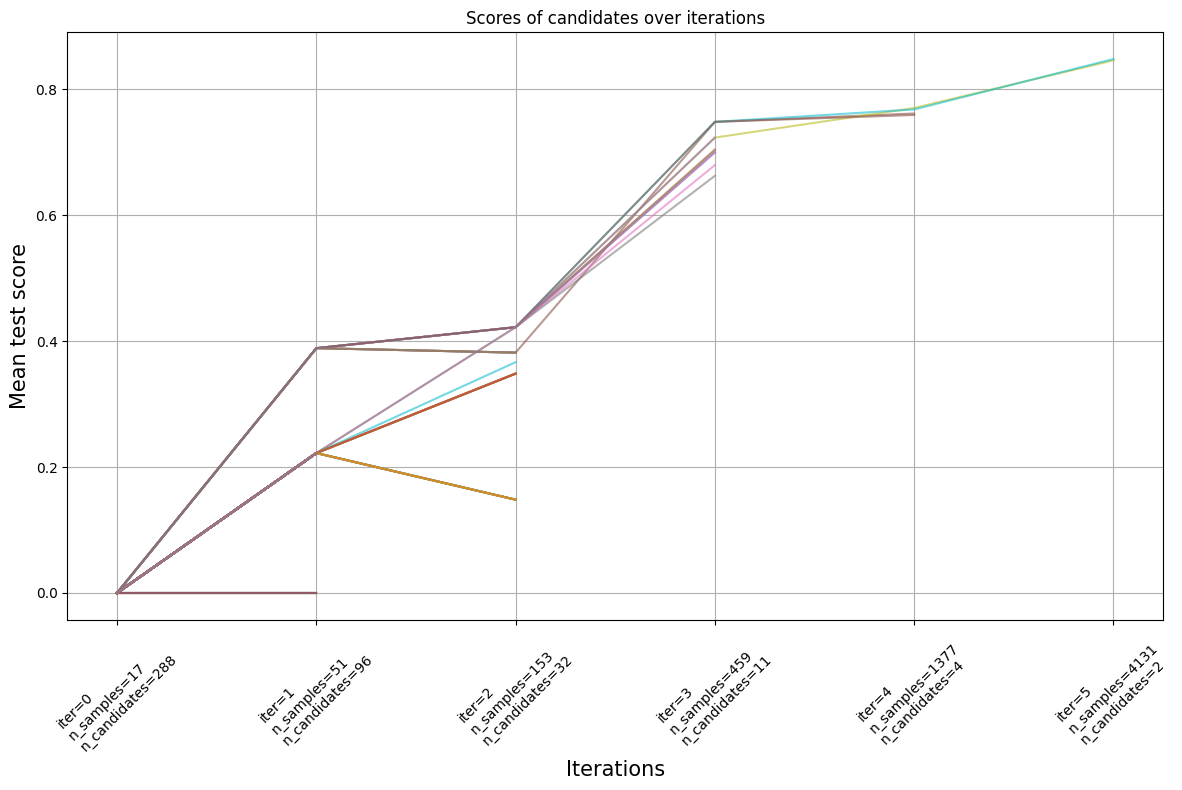

In [143]:
show_results(grid_search)

##### TF-IDF Logistic regression

In [149]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=2023))
    ]
)

In [150]:
parameter_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [151]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 154
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 154
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 14
n_resources: 462
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 2
n_candidates: 5
n_resources: 1386
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 4158
Fitting 3 folds for each of 2 candidates, totalling 6 fits
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 154
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 154
Fitting 3 folds for each of 40 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 14
n_resources: 462
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 2
n_ca

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf',
                                               LogisticRegression(random_state=2023))]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'tfidf__ngram_range': [(1, 1), (1, 2)],
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=2023, scoring='f1', verbose=1)

In [152]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1207
           1       0.99      0.69      0.81       186

    accuracy                           0.96      1393
   macro avg       0.97      0.84      0.89      1393
weighted avg       0.96      0.96      0.95      1393



In [153]:
grid_search.best_params_

{'clf__C': 1.0, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}

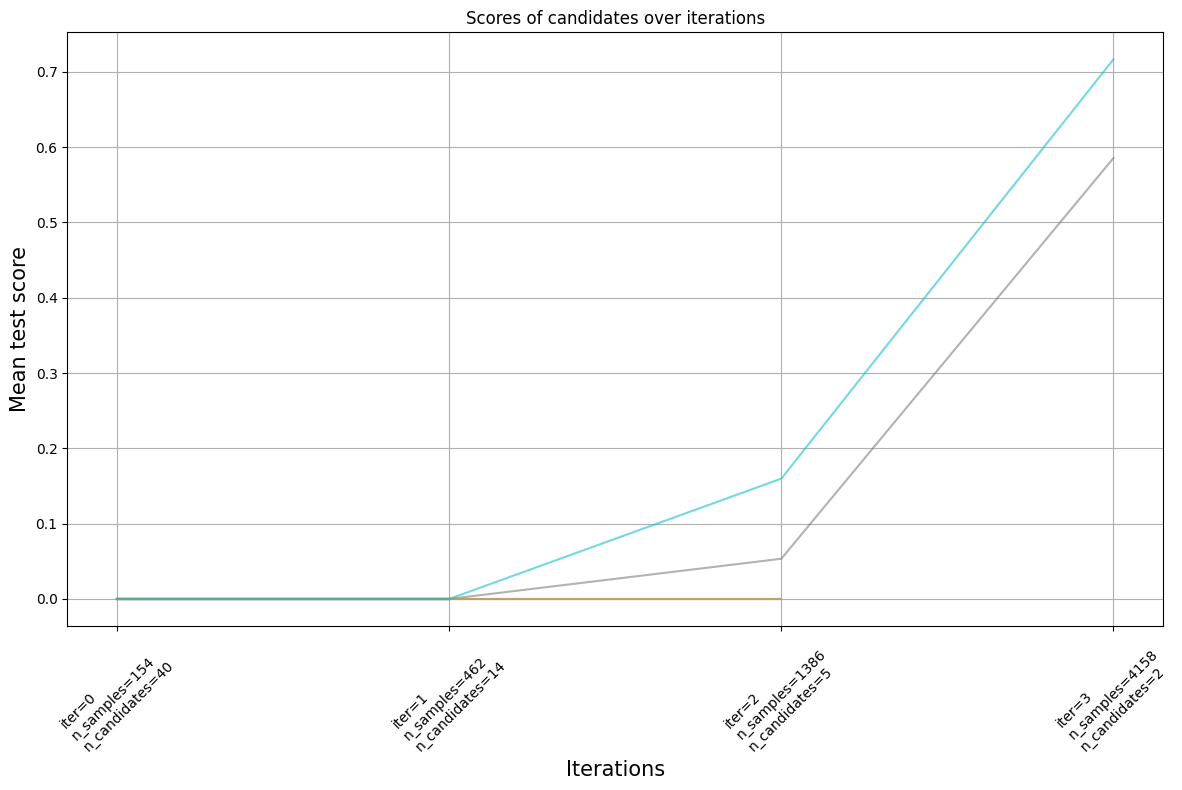

In [154]:
show_results(grid_search)


##### TF-IDF Naive Bayes

In [160]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]
)

In [161]:
parameter_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False]
}

In [162]:
%%time
grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 464
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 464
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 1392
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 4176
Fitting 3 folds for each of 3 candidates, totalling 9 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 464
max_resources_: 4179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 464
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 8
n_resources: 1392
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 3
n_resources: 4176
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 870 ms, sys:

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'clf__alpha': [0.1, 0.5, 1.0],
                                'clf__fit_prior': [True, False],
                                'tfidf__ngram_range': [(1, 1), (1, 2)],
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=2023, scoring='f1', verbose=1)

In [163]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.97      0.90      0.93       186

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [164]:
grid_search.best_params_

{'clf__alpha': 0.1,
 'clf__fit_prior': True,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2'}

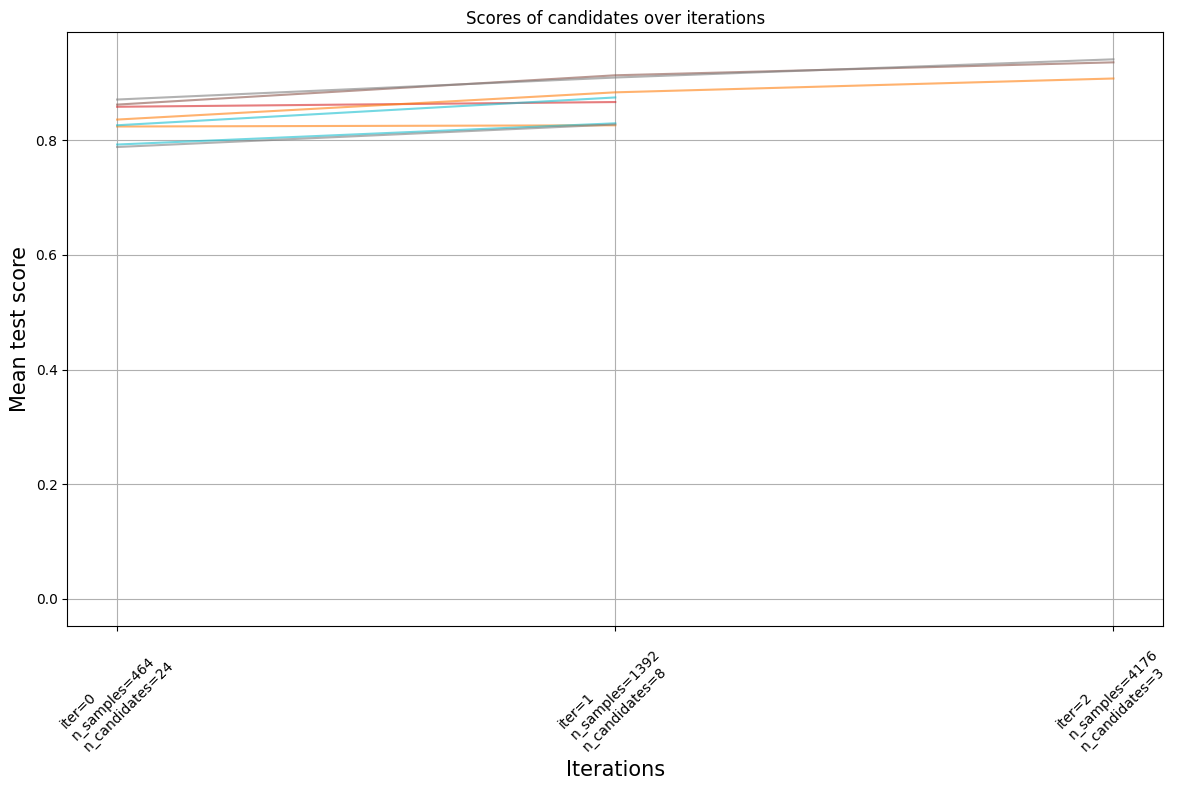

In [165]:
show_results(grid_search)

#####CountVectorizer Logistic regression

In [120]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=2023))
    ]
)

In [121]:
parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)


In [124]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1207
           1       0.97      0.63      0.76       186

    accuracy                           0.95      1393
   macro avg       0.96      0.81      0.87      1393
weighted avg       0.95      0.95      0.94      1393



In [125]:
grid_search.best_params_

{'clf__C': 0.5,
 'counter__max_df': 0.6,
 'counter__min_df': 0.01,
 'counter__ngram_range': (1, 2),
 'tfidf__norm': 'l2'}

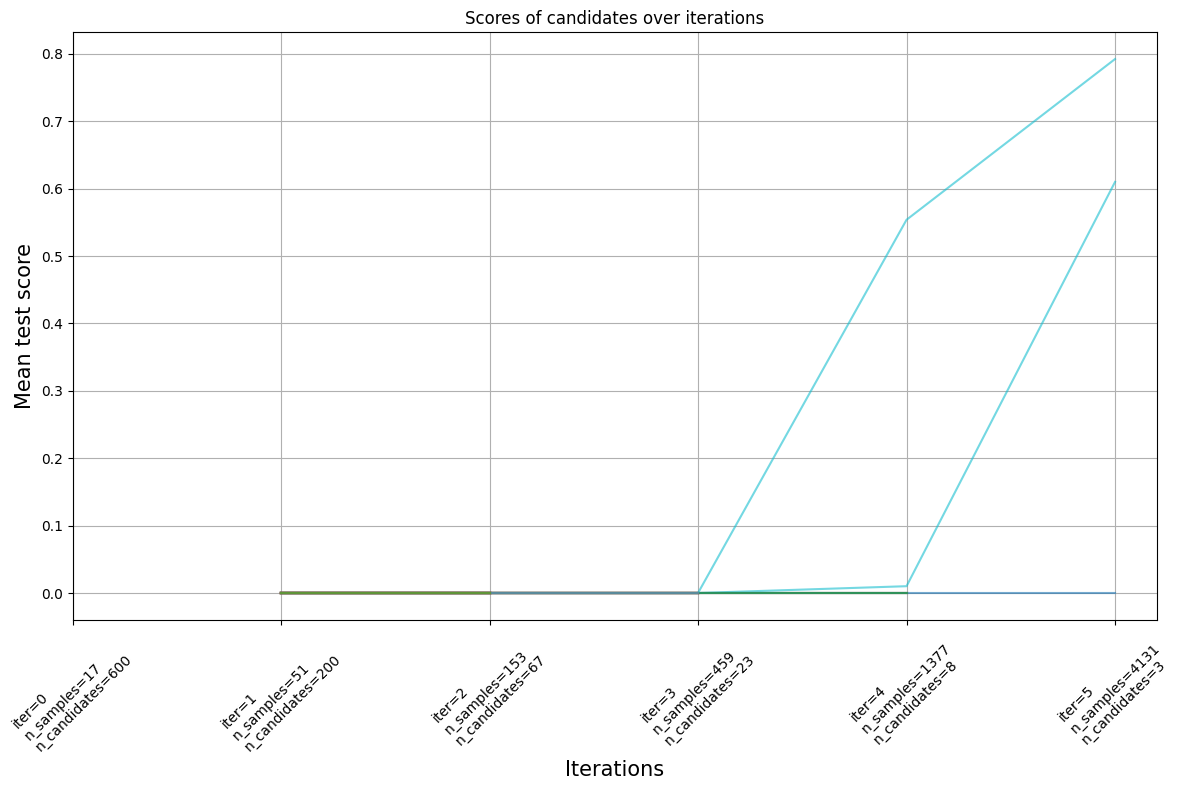

In [126]:
show_results(grid_search)

#####CountVectorizer Decision Tree

In [127]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(random_state=2023))
    ]
)

In [128]:

parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [ ]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

In [ ]:
grid_search.best_params_

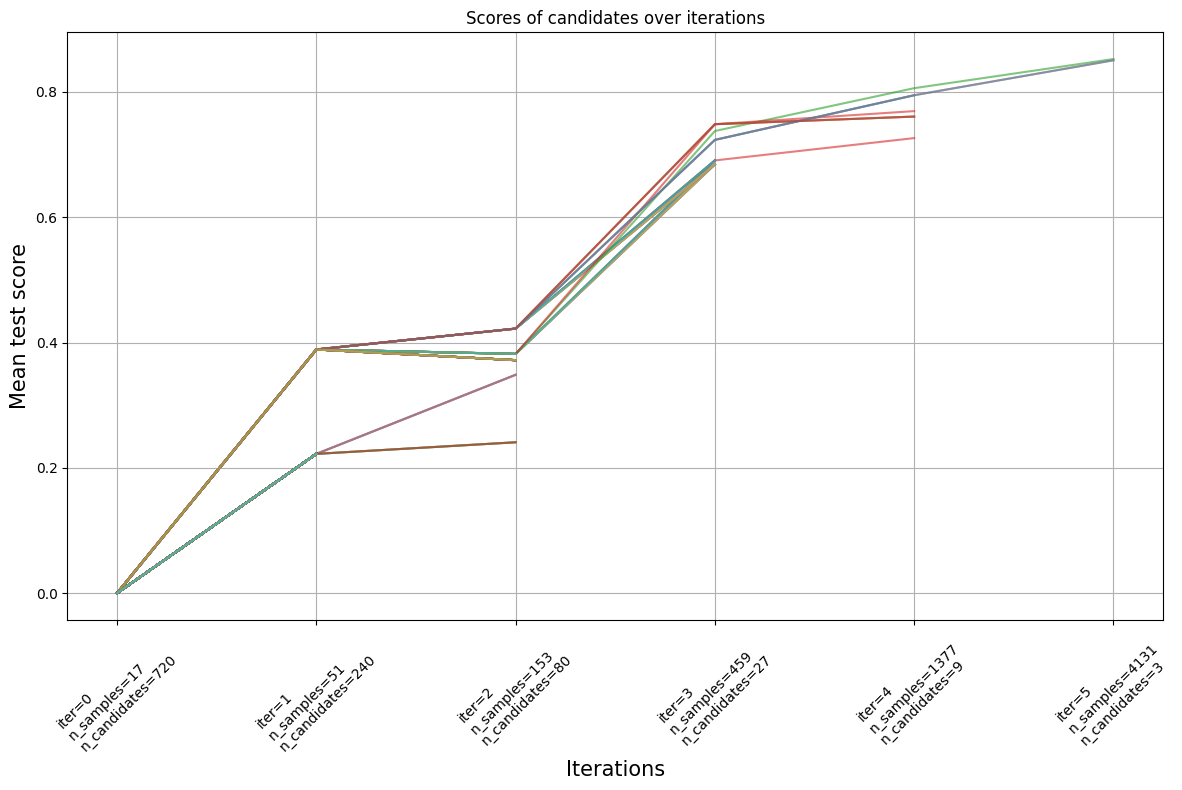

In [132]:
show_results(grid_search)

#####CountVectorizer Naive Bayes

In [133]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

In [134]:
parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "tfidf__norm": ("l1", "l2"),
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    "counter__ngram_range": ((1, 1), (1, 2))
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [136]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.96      0.85      0.91       186

    accuracy                           0.98      1393
   macro avg       0.97      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [137]:
grid_search.best_params_

{'clf__alpha': 0.1,
 'clf__fit_prior': True,
 'counter__max_df': 0.6,
 'counter__min_df': 0.001,
 'counter__ngram_range': (1, 1),
 'tfidf__norm': 'l2'}

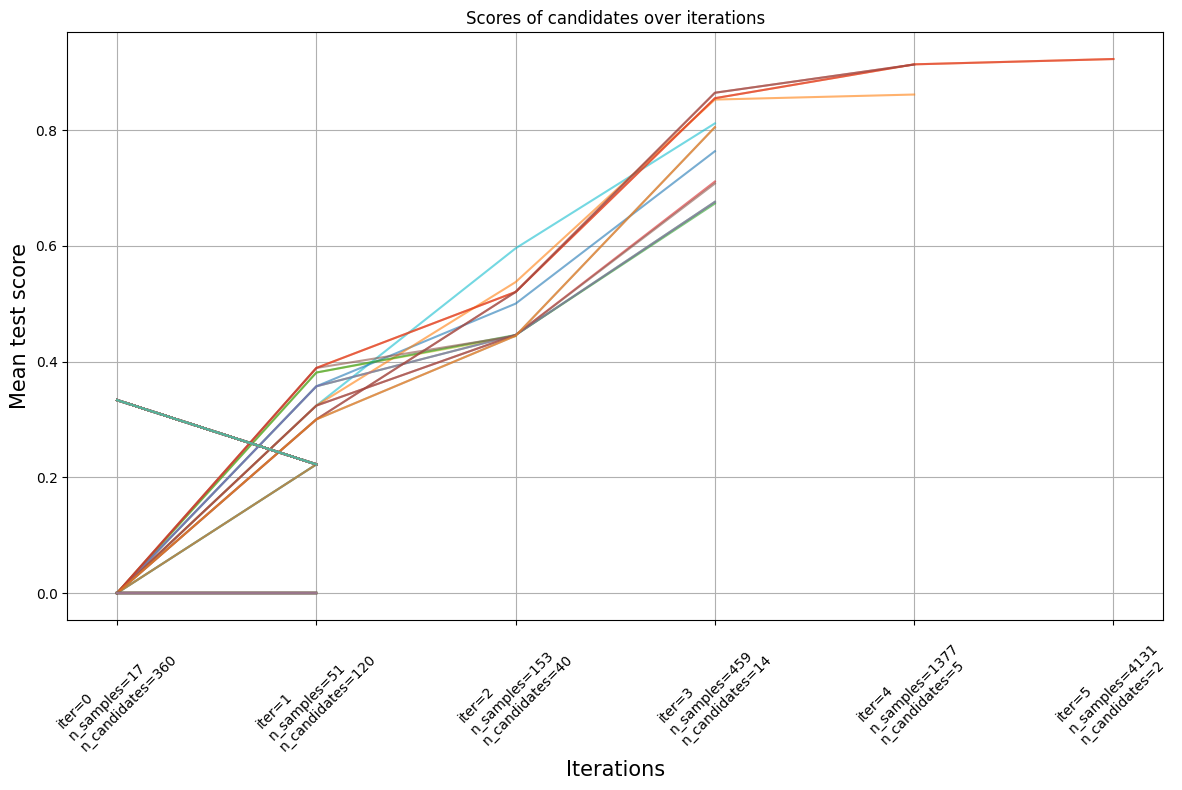

In [138]:
show_results(grid_search)

### Вывод

1. Logistic regression дает высокий precision, но низкий recall
2. Лучший результат с высокими precision и recall у Naive Bayes
3. Средний результат у Decision tree
4. TfidfVectorizer значительно улучшает метрики в отличии от CountVectorizer

Вывод: Naive Bayes с TfidfVectorizer - даст наилучший результат